#Citibike Analysis
##Problem statement
Citibike publishes trip data for bikes in NYC. The data is available to the public "for analysis, development, visualization and whatever else moves you."

##Dataset
Citibike publishes downloadable files of Citi Bike trip data. The data includes:


* Trip Duration (seconds)
* Start Time and Date
* Stop Time and Date
* Start Station Name
* End Station Name
* Station ID
* Station Lat/Long
* Bike ID
* User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
* Gender (Zero=unknown; 1=male; 2=female)
* Year of Birth


This data has been processed to remove trips that are taken by staff as they service and inspect the system. More information can be found on the [Citibike website](https://www.citibikenyc.com/system-data).

##Hypothesis
###The stations most frequented by subscribers correspond to weekday commutes
I suspect subscribers are intending to use Citibikes as part of a routine. Focusing on commutes, I'll look to answer:
1. Which stations are the most frequented by subscribers? 
2. Which stations are the most popular destinations?
3. Are the top most trafficked stations the same on weekdays as on weekends?

##Conclusions
###Additional analysis would include comparing trips taken on weekdays and weekends.
1. Stations most frequented by subscribers in 2018: West St & Chambers St 
2. 2018 subscriber's most traveled trip: West St & Chambers St   to   Pier 40 - Hudson River Park

##End product
###Input: user provided start station name, output: suggest end station names that have been historically popular



#Step 1: Combining datasets

In [0]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data for 2018 is published by month, resulting in 12 separate .csv files
files = glob.glob('2018*.csv')
print(files)

#Using glob to read the 3 files that represent 2018-Q2 in one line
df = pd.concat([pd.read_csv(f, engine='python', error_bad_lines = False) for f in glob.iglob('2018*.csv')], ignore_index = True)


In [3]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('201806-citibike-tripdata.csv', engine = 'python', error_bad_lines = False)


Skipping line 1288177: unexpected end of data


#Step 2: Explore and scrub data

In [4]:
#Shape of dataframe
print('Rows, Columns', df.shape, '\n')

#Columns in dataframe
print(df.dtypes, '\n')

#clear whitespace from column names
df.rename(columns=lambda x: x.strip(), inplace=True)

#Sanity check that data from all files has been read (Jan 2018 - Dec 2018)
min_date = min(df['starttime'])
max_date = max(df['starttime'])
print('Date range: ', min_date, ' - ', max_date)

Rows, Columns (1288175, 15) 

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object 

Date range:  2018-06-01 00:00:02.4580  -  2018-06-30 23:59:54.3620


In [5]:
#Drop rows with null values
df.dropna(inplace=True)
print(df.isnull().sum())

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
dtype: int64


##Step 2a: Remove false starts and unreasonably long trips

In [0]:
#Remove false starts, rides that don't leave the station
#ride duration less than 90 seconds AND start station id is the same as end station id

indexFalsestart = df [(df['tripduration'] < 90) & (df['start station id'] == df['end station id'])].index
df.drop(indexFalsestart , inplace=True)

In [8]:
#Remove rides that go on for longer than a reasonable trip
#12 hours = 43,200 seconds
#5 hours = 18,000 seconds
unreasonable_duration = df [(df['tripduration'] > 43200)].index
df.drop(unreasonable_duration , inplace=True)

df['tripduration'].describe()

count    1.285124e+06
mean     8.689220e+02
std      8.238346e+02
min      6.100000e+01
25%      3.870000e+02
50%      6.500000e+02
75%      1.128000e+03
max      1.799100e+04
Name: tripduration, dtype: float64

Majority of users have trip durations under 1,128 seconds / 18.8 minutes

##Step 2b: Flag roundtrips

In [9]:
#Adding column to flag rountrips (True)
df['roundtrip'] = df['start station id'] == df['end station id']

df.groupby('roundtrip')['tripduration'].agg(['count', 'mean', 'min', 'max'])

,count,mean,min,max
roundtrip,,,,
False,1262543,855.625394,61,17991
True,22581,1612.358310,90,17888


Most rides are one way. Roundrip rides are, on average, longer than one way rides

##Step 2c: Flag commuters
User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)

For this analysis, we'll assume annual members are using this subscription as part of their commutes.

In [10]:
#sanity check
print(f"Types of Citibike users: {df['usertype'].unique()}")

commuters_df = df[ (df['usertype'] == 'Subscriber')]

subscriber = commuters_df.shape
all = df.shape

s = list(subscriber)
a = list(all)


perc_subscriber = round((s[0]/a[0])*100)
print(f"Percentage of 2018 rides ridden by subscribers:  {perc_subscriber}%")

Types of Citibike users: ['Subscriber' 'Customer']
Percentage of 2018 rides ridden by subscribers:  88%


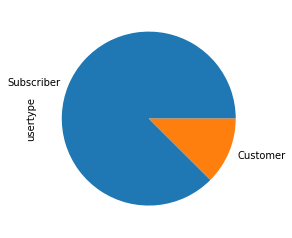

In [12]:
#visual of subscribers vs commuters
users = df['usertype'].value_counts()
users.plot.pie(y=users)

###Thoughts for additional analysis

In [0]:
#isolate weekday
#Monday =0, Tuesday=1, Wednesday=2,Thursday =3,  Friday=4 ,  Saturday =5, Sunday =6
df['sdate_dayofweek_number'] = df['starttime'].dt.dayofweek

In [0]:
#filter for rides by subscribers on weekdays, inplace

##Step 2d: Flag "valet" stations
Citi Bike offers Valet Service for expanded bike and dock availability at high volume stations during peak usage times.

In [14]:
df = commuters_df
valet = ['Grand Army Plaza & Central Park S','8 Ave & W 31 St','12 Ave & W 40 St','W 42 St & Dyer Ave','E 47 St & Park Ave','E 55 St & 3 Ave ','W 52 St & 5 Ave','W 52 St & 6 Ave','W 48th St & 5th Ave','8 Ave & West 33 St ','W 44 St & 5 Ave ','W 43 St & 5 Ave ','W 43 St & 6 Ave ','Broadway & E 22 St','E 20 St & FDR Drive','University Pl & E 14 St','W 18th St & 6 Ave','1st Ave & 16 Street','E 10 St & Avenue A','E 2 St & Avenue B','St Marks Pl & Ave 1','Allen St & Stanton St','Canal St & Rutgers St','E 7th St & Avenue A','West St & Chambers St','6 Ave & Canal St','Broadway & Battery Place','North Moore St & Greenwich St','Old Slip & Front St','Christopher St & Greenwich St','Greenwich St & W Houston St','Murray St & Greenwich St','W Broadway & Spring Street','W 95th & Broadway','1st Ave & E 68th St','11 Ave & W 27th St','N 8 St & Berry St','S 5 Pl & S 5 St','Jay St & York St','3rd Ave & Schermerhorn St']
print(f"Number of valet stations: {len(valet)}")

df['sstation_valet'] = df['start station name'].isin(valet)
df['estation_valet'] = df['end station name'].isin(valet)

Number of valet stations: 40


In [15]:
#result of data exploration and scrub
df.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,roundtrip,sstation_valet,estation_valet
0,569,2018-06-01 01:57:20.5140,2018-06-01 02:06:50.0880,72,W 52 St & 11 Ave,40.767272,-73.993929,173,Broadway & W 49 St,40.760683,-73.984527,21481,Subscriber,1999,1,False,False,False
1,480,2018-06-01 02:02:42.3980,2018-06-01 02:10:43.3540,72,W 52 St & 11 Ave,40.767272,-73.993929,477,W 41 St & 8 Ave,40.756405,-73.990026,19123,Subscriber,1988,1,False,False,False
2,692,2018-06-01 02:04:23.6240,2018-06-01 02:15:55.7470,72,W 52 St & 11 Ave,40.767272,-73.993929,457,Broadway & W 58 St,40.766953,-73.981693,26983,Subscriber,1986,1,False,False,False
3,664,2018-06-01 03:00:55.4610,2018-06-01 03:11:59.9060,72,W 52 St & 11 Ave,40.767272,-73.993929,379,W 31 St & 7 Ave,40.749156,-73.991600,26742,Subscriber,1973,1,False,False,False
4,818,2018-06-01 06:04:54.4270,2018-06-01 06:18:32.6170,72,W 52 St & 11 Ave,40.767272,-73.993929,459,W 20 St & 11 Ave,40.746745,-74.007756,26386,Subscriber,1984,1,False,False,False


#Step 3: Analyze rides

In [16]:
#Exploration summary
print(f"Number of unique start stations: {df['start station id'].nunique()}")
print(f"Number of unique end stations: {df['end station id'].nunique()}")

Number of unique start stations: 358
Number of unique end stations: 769


##Interesting there are more end stations that start stations!

In [17]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender', 'roundtrip', 'sstation_valet',
       'estation_valet'],
      dtype='object')

In [18]:
#how many rides start from valet stations?
valetstart = df[df['sstation_valet']]
count_valetstart = valetstart.tripduration.count()
print(f'Number of rides starting at a valet station: {count_valetstart}')


Number of rides starting at a valet station: 97835


In [35]:
#most popular valet start station
valetstart['start station name'].value_counts()

West St & Chambers St                10688
Broadway & E 22 St                   10662
Christopher St & Greenwich St         8290
E 47 St & Park Ave                    7714
12 Ave & W 40 St                      7566
University Pl & E 14 St               7008
E 10 St & Avenue A                    5825
Canal St & Rutgers St                 5579
Greenwich St & W Houston St           5342
Grand Army Plaza & Central Park S     5118
E 20 St & FDR Drive                   5004
Allen St & Stanton St                 4810
6 Ave & Canal St                      4562
E 2 St & Avenue B                     3770
S 5 Pl & S 5 St                       3196
Old Slip & Front St                   1890
W 52 St & 5 Ave                        811
Name: start station name, dtype: int64

In [19]:
valetstart_oneway = df[ df['sstation_valet'] & (df['roundtrip'] == False)]
per_oneway = (valetstart_oneway.tripduration.count()/count_valetstart)*100
print("Percent of valet starts that are one way rides: ",round(per_oneway), "%")
valetstart_roundtrip = df[ df['sstation_valet'] & df['roundtrip']]
per_roundtrip = (valetstart_roundtrip.tripduration.count()/count_valetstart)*100
print('Percent of valet starts that are roundtrip rides: ',round(per_roundtrip), '%')
valetstart_valetstop = df[ df['sstation_valet'] & df['estation_valet']]
per_valettovalet = (valetstart_valetstop.tripduration.count()/count_valetstart)*100
print('Percent of valet starts that end at another valet station: ', round(per_valettovalet), '%')

Percent of valet starts that are one way rides:  98.0 %
Percent of valet starts that are roundtrip rides:  2.0 %
Percent of valet starts that end at another valet station:  11.0 %


##Let's focus on the majority of the rides people embark on from valet stations: one way rides 

Text(0.5, 1.0, 'Valet Start - One way')

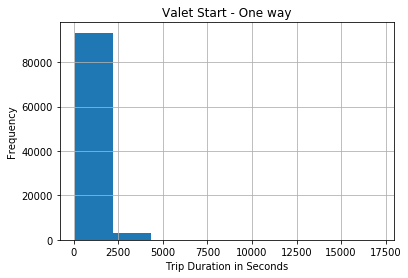

In [20]:
#are a lot of the valet start - one way rides similar lengths of time?
#yes
valetstart_oneway.hist(column='tripduration', bins=8)
plt.ylabel('Frequency')
plt.xlabel('Trip Duration in Seconds')
plt.title('Valet Start - One way')

Text(0.5, 1.0, 'Valet Start - Roundtrip')

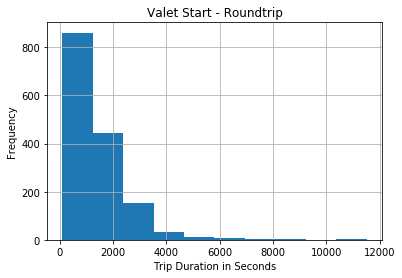

In [21]:
#are a lot of the valet start - roundtrip rides similar lengths of time?
#yes with outliers
valetstart_roundtrip.hist(column='tripduration', bins=10)
plt.ylabel('Frequency')
plt.xlabel('Trip Duration in Seconds')
plt.title('Valet Start - Roundtrip')

Text(0.5, 1.0, 'Valet Start - One way - Valet End')

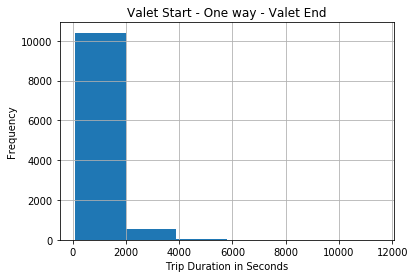

In [22]:
#are a lot of the valet start - one way rides - valet end similar lengths of time?
#majority, yes
valetstart_valetstop.hist(column='tripduration', bins=6)
plt.ylabel('Frequency')
plt.xlabel('Trip Duration in Seconds')
plt.title('Valet Start - One way - Valet End')

Makes sense: commutes would be one way rides relatively shorter durations compared to roundtrip rides.
##Where are they going?

In [28]:
#what are the most popular valet start - one way trips?
trips = valetstart_oneway.groupby('start station name')['end station name'].value_counts().sort_values(ascending=False)
trips.head(25)

start station name             end station name             
West St & Chambers St          Pier 40 - Hudson River Park      360
12 Ave & W 40 St               West St & Chambers St            347
West St & Chambers St          Christopher St & Greenwich St    331
                               12 Ave & W 40 St                 319
E 10 St & Avenue A             Lafayette St & E 8 St            296
                               Broadway & E 14 St               296
6 Ave & Canal St               Barclay St & Church St           289
West St & Chambers St          Washington St & Gansevoort St    288
E 47 St & Park Ave             W 33 St & 7 Ave                  271
Greenwich St & W Houston St    West St & Chambers St            270
Broadway & E 22 St             E 17 St & Broadway               261
West St & Chambers St          Barrow St & Hudson St            258
E 47 St & Park Ave             W 41 St & 8 Ave                  252
Christopher St & Greenwich St  Washington St & Gansevoo

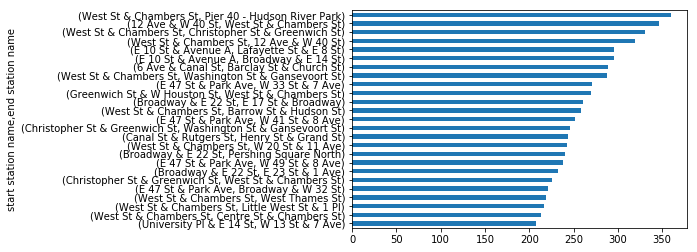

In [29]:
plot_trips = valetstart_oneway.groupby('start station name')['end station name'].value_counts().sort_values(ascending=False).head(25)
plot_trips.sort_values(ascending=True).plot(kind='barh')